In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns

base_path = '/home/maj/data/insideairbnb/processed/'
train = pd.read_csv(base_path + 'train.csv', low_memory=False)
validate = pd.read_csv(base_path + 'validate.csv', low_memory=False)
test = pd.read_csv(base_path + 'test.csv', low_memory=False)
train_validate = pd.concat([train, validate])

train_validate.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,...,house_rules_p,review_len,review_spec,review_num,svd_R,review_p,review_s,if_monthly,distance_min,price_log
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.432058,0.000776,0.997301,0.457991,0.001416,0.003226,-0.000436,0.000838,0.004530,0.546703,...,0.000111,-0.000343,-0.006913,-0.004571,0.005599,0.002076,0.001881,-0.007906,-0.003711,4.855212
std,0.495391,0.999817,0.051884,0.498261,1.001676,1.003955,1.013899,1.005067,0.982705,0.497843,...,1.000088,0.993335,0.956155,0.990426,0.992535,0.993063,0.992220,0.986144,0.999398,0.698210
min,0.000000,-0.243628,0.000000,0.000000,-1.435661,-1.621742,-0.246156,-0.634275,-12.209914,0.000000,...,-6.169202,-2.179418,-1.110441,-0.884758,-6.420100,-8.742889,-5.402021,-0.266410,-1.065591,2.302585
25%,0.000000,-0.238199,1.000000,0.000000,-0.937338,-0.481991,-0.246156,-0.590649,-0.080458,0.000000,...,-0.527809,-0.495224,-0.254877,-0.489322,-0.317731,-0.263927,-0.196427,-0.266410,-0.557558,4.369448
50%,0.000000,-0.232771,1.000000,0.000000,0.059306,-0.481991,-0.182337,-0.401604,0.242994,1.000000,...,-0.527809,0.004908,-0.142047,-0.108233,0.009905,-0.000321,0.029038,-0.266410,-0.323735,4.828314
75%,1.000000,-0.194770,1.000000,1.000000,1.055951,0.657761,-0.118518,0.150989,0.566446,1.000000,...,0.405026,0.297912,-0.011113,0.135818,0.502167,0.372443,0.394104,-0.266410,0.122526,5.298317
max,1.000000,9.636534,1.000000,1.000000,2.052595,4.077015,50.745168,11.275558,0.728172,1.000000,...,6.523932,18.193288,28.370835,19.118522,4.899802,5.618845,4.126983,3.753609,6.003178,6.906755


In [2]:
drop_columns = ['price_log', 'host_has_profile_pic', 'is_business_travel_ready', 'distance_to_san_diego_zoo']
X_train = train.drop(drop_columns, axis=1).to_numpy()
X_validate = validate.drop(drop_columns, axis=1).to_numpy()

# https://www.tensorflow.org/tutorials/keras/regression
# https://stackoverflow.com/questions/55924789/normalization-of-input-data-in-keras

# need to 'pickle' model creation to allow for multiprocess parallel execution for grid search
# see https://github.com/keras-team/keras/issues/6862
def create_model(neurons):
    m = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) # also sgd, keras.optimizers.RMSprop
    return m


# test the model
m = create_model(64)
m.fit(X_train,
    train.price_log.to_numpy(),
    epochs=900,
    batch_size=512,
    validation_data=(X_validate, validate.price_log.to_numpy()),
    verbose = 1)
m.summary()

Train on 7243 samples, validate on 1279 samples
Epoch 1/900
7243/7243 [==============================] - 2s 226us/sample - loss: 26.9168 - mae: 5.0796 - mse: 26.9168 - val_loss: 19.0442 - val_mae: 4.2886 - val_mse: 19.0442
Epoch 2/900
7243/7243 [==============================] - 0s 20us/sample - loss: 16.6967 - mae: 3.9646 - mse: 16.6967 - val_loss: 15.6115 - val_mae: 3.8558 - val_mse: 15.6115
Epoch 3/900
7243/7243 [==============================] - 0s 20us/sample - loss: 9.3487 - mae: 2.8947 - mse: 9.3487 - val_loss: 11.9708 - val_mae: 3.3351 - val_mse: 11.9708
Epoch 4/900
7243/7243 [==============================] - 0s 21us/sample - loss: 4.1825 - mae: 1.8090 - mse: 4.1825 - val_loss: 8.2512 - val_mae: 2.7247 - val_mse: 8.2512
Epoch 5/900
7243/7243 [==============================] - 0s 21us/sample - loss: 1.8109 - mae: 1.0693 - mse: 1.8109 - val_loss: 5.3905 - val_mae: 2.1696 - val_mse: 5.3905
Epoch 6/900
7243/7243 [==============================] - 0s 21us/sample - loss: 1.1823 - ma

7243/7243 [==============================] - 0s 20us/sample - loss: 0.2399 - mae: 0.3745 - mse: 0.2399 - val_loss: 0.1861 - val_mae: 0.3281 - val_mse: 0.1861
Epoch 49/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.2432 - mae: 0.3783 - mse: 0.2432 - val_loss: 0.1814 - val_mae: 0.3243 - val_mse: 0.1814
Epoch 50/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.2381 - mae: 0.3745 - mse: 0.2381 - val_loss: 0.1811 - val_mae: 0.3222 - val_mse: 0.1811
Epoch 51/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.2435 - mae: 0.3796 - mse: 0.2435 - val_loss: 0.1810 - val_mae: 0.3229 - val_mse: 0.1810
Epoch 52/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.2350 - mae: 0.3742 - mse: 0.2350 - val_loss: 0.1813 - val_mae: 0.3231 - val_mse: 0.1813
Epoch 53/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.2448 - mae: 0.3802 - mse: 0.2448 - val_loss: 0.1796 - val_mae: 0.3216 - val

Epoch 96/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1902 - mae: 0.3336 - mse: 0.1902 - val_loss: 0.1651 - val_mae: 0.3076 - val_mse: 0.1651
Epoch 97/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1927 - mae: 0.3345 - mse: 0.1927 - val_loss: 0.1652 - val_mae: 0.3056 - val_mse: 0.1652
Epoch 98/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1895 - mae: 0.3295 - mse: 0.1895 - val_loss: 0.1618 - val_mae: 0.3068 - val_mse: 0.1618
Epoch 99/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1908 - mae: 0.3315 - mse: 0.1908 - val_loss: 0.1751 - val_mae: 0.3147 - val_mse: 0.1751
Epoch 100/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1910 - mae: 0.3335 - mse: 0.1910 - val_loss: 0.1615 - val_mae: 0.3062 - val_mse: 0.1615
Epoch 101/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1905 - mae: 0.3339 - mse: 0.1905 - val_loss: 0.1660 - val_ma

Epoch 144/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1711 - mae: 0.3160 - mse: 0.1711 - val_loss: 0.1677 - val_mae: 0.3055 - val_mse: 0.1677
Epoch 145/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1703 - mae: 0.3137 - mse: 0.1703 - val_loss: 0.1638 - val_mae: 0.3019 - val_mse: 0.1638
Epoch 146/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1624 - mae: 0.3060 - mse: 0.1624 - val_loss: 0.1593 - val_mae: 0.2998 - val_mse: 0.1593
Epoch 147/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1666 - mae: 0.3109 - mse: 0.1666 - val_loss: 0.1625 - val_mae: 0.3023 - val_mse: 0.1625
Epoch 148/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1699 - mae: 0.3128 - mse: 0.1699 - val_loss: 0.1764 - val_mae: 0.3142 - val_mse: 0.1764
Epoch 149/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1699 - mae: 0.3149 - mse: 0.1699 - val_loss: 0.1680 - va

7243/7243 [==============================] - 0s 21us/sample - loss: 0.1573 - mae: 0.3025 - mse: 0.1573 - val_loss: 0.1588 - val_mae: 0.2980 - val_mse: 0.1588
Epoch 192/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1564 - mae: 0.3022 - mse: 0.1564 - val_loss: 0.1616 - val_mae: 0.3025 - val_mse: 0.1616
Epoch 193/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1515 - mae: 0.2947 - mse: 0.1515 - val_loss: 0.1592 - val_mae: 0.3014 - val_mse: 0.1592
Epoch 194/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1523 - mae: 0.2966 - mse: 0.1523 - val_loss: 0.1599 - val_mae: 0.3004 - val_mse: 0.1599
Epoch 195/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1518 - mae: 0.2950 - mse: 0.1518 - val_loss: 0.1559 - val_mae: 0.2991 - val_mse: 0.1559
Epoch 196/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1465 - mae: 0.2907 - mse: 0.1465 - val_loss: 0.1629 - val_mae: 0.3021 

Epoch 239/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1429 - mae: 0.2857 - mse: 0.1429 - val_loss: 0.1563 - val_mae: 0.2956 - val_mse: 0.1563
Epoch 240/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1438 - mae: 0.2889 - mse: 0.1438 - val_loss: 0.1577 - val_mae: 0.2972 - val_mse: 0.1577
Epoch 241/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1400 - mae: 0.2838 - mse: 0.1400 - val_loss: 0.1538 - val_mae: 0.2952 - val_mse: 0.1538
Epoch 242/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1422 - mae: 0.2850 - mse: 0.1422 - val_loss: 0.1598 - val_mae: 0.3014 - val_mse: 0.1598
Epoch 243/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1385 - mae: 0.2842 - mse: 0.1385 - val_loss: 0.1591 - val_mae: 0.2979 - val_mse: 0.1591
Epoch 244/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1427 - mae: 0.2892 - mse: 0.1427 - val_loss: 0.1580 - va

7243/7243 [==============================] - 0s 20us/sample - loss: 0.1332 - mae: 0.2775 - mse: 0.1332 - val_loss: 0.1592 - val_mae: 0.3005 - val_mse: 0.1592
Epoch 287/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1293 - mae: 0.2733 - mse: 0.1293 - val_loss: 0.1555 - val_mae: 0.2966 - val_mse: 0.1555
Epoch 288/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1303 - mae: 0.2761 - mse: 0.1303 - val_loss: 0.1716 - val_mae: 0.3116 - val_mse: 0.1716
Epoch 289/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1327 - mae: 0.2789 - mse: 0.1327 - val_loss: 0.1660 - val_mae: 0.3052 - val_mse: 0.1660
Epoch 290/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1350 - mae: 0.2819 - mse: 0.1350 - val_loss: 0.1603 - val_mae: 0.3008 - val_mse: 0.1603
Epoch 291/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1350 - mae: 0.2807 - mse: 0.1350 - val_loss: 0.1732 - val_mae: 0.3113 

Epoch 334/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1198 - mae: 0.2640 - mse: 0.1198 - val_loss: 0.1602 - val_mae: 0.2998 - val_mse: 0.1602
Epoch 335/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1261 - mae: 0.2702 - mse: 0.1261 - val_loss: 0.1555 - val_mae: 0.2941 - val_mse: 0.1555
Epoch 336/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1216 - mae: 0.2652 - mse: 0.1216 - val_loss: 0.1557 - val_mae: 0.2961 - val_mse: 0.1557
Epoch 337/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1237 - mae: 0.2671 - mse: 0.1237 - val_loss: 0.1541 - val_mae: 0.2939 - val_mse: 0.1541
Epoch 338/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1223 - mae: 0.2669 - mse: 0.1223 - val_loss: 0.1593 - val_mae: 0.2989 - val_mse: 0.1593
Epoch 339/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1244 - mae: 0.2683 - mse: 0.1244 - val_loss: 0.1589 - va

7243/7243 [==============================] - 0s 22us/sample - loss: 0.1121 - mae: 0.2544 - mse: 0.1121 - val_loss: 0.1604 - val_mae: 0.3008 - val_mse: 0.1604
Epoch 382/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1143 - mae: 0.2593 - mse: 0.1143 - val_loss: 0.1522 - val_mae: 0.2919 - val_mse: 0.1522
Epoch 383/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1171 - mae: 0.2616 - mse: 0.1171 - val_loss: 0.1491 - val_mae: 0.2889 - val_mse: 0.1491
Epoch 384/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1133 - mae: 0.2583 - mse: 0.1133 - val_loss: 0.1497 - val_mae: 0.2889 - val_mse: 0.1497
Epoch 385/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1195 - mae: 0.2652 - mse: 0.1195 - val_loss: 0.1496 - val_mae: 0.2895 - val_mse: 0.1496
Epoch 386/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1246 - mae: 0.2722 - mse: 0.1246 - val_loss: 0.1654 - val_mae: 0.3049 

Epoch 429/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1063 - mae: 0.2499 - mse: 0.1063 - val_loss: 0.1473 - val_mae: 0.2867 - val_mse: 0.1473
Epoch 430/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1099 - mae: 0.2531 - mse: 0.1099 - val_loss: 0.1504 - val_mae: 0.2914 - val_mse: 0.1504
Epoch 431/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1069 - mae: 0.2488 - mse: 0.1069 - val_loss: 0.1608 - val_mae: 0.3001 - val_mse: 0.1608
Epoch 432/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1114 - mae: 0.2554 - mse: 0.1114 - val_loss: 0.1616 - val_mae: 0.3016 - val_mse: 0.1616
Epoch 433/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.1067 - mae: 0.2505 - mse: 0.1067 - val_loss: 0.1497 - val_mae: 0.2887 - val_mse: 0.1497
Epoch 434/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1063 - mae: 0.2480 - mse: 0.1063 - val_loss: 0.1517 - va

7243/7243 [==============================] - 0s 22us/sample - loss: 0.1070 - mae: 0.2491 - mse: 0.1070 - val_loss: 0.1568 - val_mae: 0.2955 - val_mse: 0.1568
Epoch 477/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1087 - mae: 0.2527 - mse: 0.1087 - val_loss: 0.1552 - val_mae: 0.2938 - val_mse: 0.1552
Epoch 478/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1073 - mae: 0.2506 - mse: 0.1073 - val_loss: 0.1526 - val_mae: 0.2910 - val_mse: 0.1526
Epoch 479/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1047 - mae: 0.2469 - mse: 0.1047 - val_loss: 0.1524 - val_mae: 0.2917 - val_mse: 0.1524
Epoch 480/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1029 - mae: 0.2444 - mse: 0.1029 - val_loss: 0.1486 - val_mae: 0.2879 - val_mse: 0.1486
Epoch 481/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.1040 - mae: 0.2471 - mse: 0.1040 - val_loss: 0.1496 - val_mae: 0.2894 

Epoch 524/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1086 - mae: 0.2532 - mse: 0.1086 - val_loss: 0.1528 - val_mae: 0.2943 - val_mse: 0.1528
Epoch 525/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0999 - mae: 0.2395 - mse: 0.0999 - val_loss: 0.1573 - val_mae: 0.2988 - val_mse: 0.1573
Epoch 526/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1029 - mae: 0.2436 - mse: 0.1029 - val_loss: 0.1494 - val_mae: 0.2899 - val_mse: 0.1494
Epoch 527/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0987 - mae: 0.2394 - mse: 0.0987 - val_loss: 0.1510 - val_mae: 0.2918 - val_mse: 0.1510
Epoch 528/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1034 - mae: 0.2466 - mse: 0.1034 - val_loss: 0.1485 - val_mae: 0.2890 - val_mse: 0.1485
Epoch 529/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.1054 - mae: 0.2481 - mse: 0.1054 - val_loss: 0.1491 - va

7243/7243 [==============================] - 0s 20us/sample - loss: 0.1019 - mae: 0.2438 - mse: 0.1019 - val_loss: 0.1538 - val_mae: 0.2933 - val_mse: 0.1538
Epoch 572/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0967 - mae: 0.2386 - mse: 0.0967 - val_loss: 0.1490 - val_mae: 0.2916 - val_mse: 0.1490
Epoch 573/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0976 - mae: 0.2390 - mse: 0.0976 - val_loss: 0.1513 - val_mae: 0.2930 - val_mse: 0.1513
Epoch 574/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0984 - mae: 0.2399 - mse: 0.0984 - val_loss: 0.1510 - val_mae: 0.2912 - val_mse: 0.1510
Epoch 575/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0978 - mae: 0.2398 - mse: 0.0978 - val_loss: 0.1497 - val_mae: 0.2905 - val_mse: 0.1497
Epoch 576/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0999 - mae: 0.2415 - mse: 0.0999 - val_loss: 0.1537 - val_mae: 0.2940 

Epoch 619/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0988 - mae: 0.2406 - mse: 0.0988 - val_loss: 0.1529 - val_mae: 0.2925 - val_mse: 0.1529
Epoch 620/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0916 - mae: 0.2313 - mse: 0.0916 - val_loss: 0.1534 - val_mae: 0.2927 - val_mse: 0.1534
Epoch 621/900
7243/7243 [==============================] - 0s 23us/sample - loss: 0.0949 - mae: 0.2354 - mse: 0.0949 - val_loss: 0.1492 - val_mae: 0.2907 - val_mse: 0.1492
Epoch 622/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0946 - mae: 0.2348 - mse: 0.0946 - val_loss: 0.1470 - val_mae: 0.2875 - val_mse: 0.1470
Epoch 623/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0949 - mae: 0.2346 - mse: 0.0949 - val_loss: 0.1482 - val_mae: 0.2905 - val_mse: 0.1482
Epoch 624/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0904 - mae: 0.2306 - mse: 0.0904 - val_loss: 0.1500 - va

7243/7243 [==============================] - 0s 19us/sample - loss: 0.0930 - mae: 0.2329 - mse: 0.0930 - val_loss: 0.1593 - val_mae: 0.3004 - val_mse: 0.1593
Epoch 667/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0916 - mae: 0.2331 - mse: 0.0916 - val_loss: 0.1604 - val_mae: 0.3005 - val_mse: 0.1604
Epoch 668/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0940 - mae: 0.2345 - mse: 0.0940 - val_loss: 0.1485 - val_mae: 0.2893 - val_mse: 0.1485
Epoch 669/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0916 - mae: 0.2309 - mse: 0.0916 - val_loss: 0.1519 - val_mae: 0.2926 - val_mse: 0.1519
Epoch 670/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0898 - mae: 0.2270 - mse: 0.0898 - val_loss: 0.1469 - val_mae: 0.2880 - val_mse: 0.1469
Epoch 671/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0897 - mae: 0.2268 - mse: 0.0897 - val_loss: 0.1454 - val_mae: 0.2882 

Epoch 714/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0983 - mae: 0.2414 - mse: 0.0983 - val_loss: 0.1733 - val_mae: 0.3146 - val_mse: 0.1733
Epoch 715/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0999 - mae: 0.2409 - mse: 0.0999 - val_loss: 0.1510 - val_mae: 0.2924 - val_mse: 0.1510
Epoch 716/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0963 - mae: 0.2377 - mse: 0.0963 - val_loss: 0.1467 - val_mae: 0.2900 - val_mse: 0.1467
Epoch 717/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0885 - mae: 0.2283 - mse: 0.0885 - val_loss: 0.1463 - val_mae: 0.2885 - val_mse: 0.1463
Epoch 718/900
7243/7243 [==============================] - 0s 22us/sample - loss: 0.0908 - mae: 0.2281 - mse: 0.0908 - val_loss: 0.1477 - val_mae: 0.2882 - val_mse: 0.1477
Epoch 719/900
7243/7243 [==============================] - 0s 21us/sample - loss: 0.0909 - mae: 0.2299 - mse: 0.0909 - val_loss: 0.1458 - va

7243/7243 [==============================] - 0s 20us/sample - loss: 0.0863 - mae: 0.2238 - mse: 0.0863 - val_loss: 0.1502 - val_mae: 0.2902 - val_mse: 0.1502
Epoch 762/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0892 - mae: 0.2285 - mse: 0.0892 - val_loss: 0.1575 - val_mae: 0.2969 - val_mse: 0.1575
Epoch 763/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0898 - mae: 0.2298 - mse: 0.0898 - val_loss: 0.1547 - val_mae: 0.2947 - val_mse: 0.1547
Epoch 764/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0875 - mae: 0.2260 - mse: 0.0875 - val_loss: 0.1501 - val_mae: 0.2907 - val_mse: 0.1501
Epoch 765/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0857 - mae: 0.2231 - mse: 0.0857 - val_loss: 0.1497 - val_mae: 0.2899 - val_mse: 0.1497
Epoch 766/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0861 - mae: 0.2258 - mse: 0.0861 - val_loss: 0.1460 - val_mae: 0.2865 

Epoch 809/900
7243/7243 [==============================] - 0s 17us/sample - loss: 0.0820 - mae: 0.2197 - mse: 0.0820 - val_loss: 0.1451 - val_mae: 0.2844 - val_mse: 0.1451
Epoch 810/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0864 - mae: 0.2231 - mse: 0.0864 - val_loss: 0.1488 - val_mae: 0.2895 - val_mse: 0.1488
Epoch 811/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0880 - mae: 0.2265 - mse: 0.0880 - val_loss: 0.1574 - val_mae: 0.2975 - val_mse: 0.1574
Epoch 812/900
7243/7243 [==============================] - 0s 18us/sample - loss: 0.0888 - mae: 0.2275 - mse: 0.0888 - val_loss: 0.1629 - val_mae: 0.3036 - val_mse: 0.1629
Epoch 813/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0856 - mae: 0.2239 - mse: 0.0856 - val_loss: 0.1609 - val_mae: 0.3003 - val_mse: 0.1609
Epoch 814/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0858 - mae: 0.2226 - mse: 0.0858 - val_loss: 0.1516 - va

7243/7243 [==============================] - 0s 17us/sample - loss: 0.0864 - mae: 0.2236 - mse: 0.0864 - val_loss: 0.1499 - val_mae: 0.2917 - val_mse: 0.1499
Epoch 857/900
7243/7243 [==============================] - 0s 18us/sample - loss: 0.0866 - mae: 0.2251 - mse: 0.0866 - val_loss: 0.1492 - val_mae: 0.2898 - val_mse: 0.1492
Epoch 858/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0858 - mae: 0.2237 - mse: 0.0858 - val_loss: 0.1506 - val_mae: 0.2910 - val_mse: 0.1506
Epoch 859/900
7243/7243 [==============================] - 0s 18us/sample - loss: 0.0875 - mae: 0.2249 - mse: 0.0875 - val_loss: 0.1541 - val_mae: 0.2929 - val_mse: 0.1541
Epoch 860/900
7243/7243 [==============================] - 0s 19us/sample - loss: 0.0860 - mae: 0.2244 - mse: 0.0860 - val_loss: 0.1512 - val_mae: 0.2894 - val_mse: 0.1512
Epoch 861/900
7243/7243 [==============================] - 0s 20us/sample - loss: 0.0867 - mae: 0.2246 - mse: 0.0867 - val_loss: 0.1569 - val_mae: 0.2951 

In [3]:
%%time
grid = GridSearchCV(estimator=KerasRegressor(build_fn=create_model, verbose=0),
                    param_grid=dict(neurons=[16, 32, 48, 64, 96, 128, 144]),
                    n_jobs=1) # OOM if set 2?

grid_result = grid.fit(X_train,
                       train.price_log.to_numpy(),
                       epochs=900,
                       batch_size=512,
                       validation_data=(X_validate, validate.price_log.to_numpy()),
)

CPU times: user 1h 42min 25s, sys: 8min 14s, total: 1h 50min 40s
Wall time: 1h 6min 22s


In [4]:
m = grid_result.best_estimator_.model
grid_result.best_params_

{'neurons': 128}

In [5]:
X_test = test.drop(drop_columns, axis=1).to_numpy()
m.evaluate(X_test, test.price_log.to_numpy())

1504/1504 [==============================] - 0s 190us/sample - loss: 0.1469 - mae: 0.2839 - mse: 0.1469


[0.14690882554079623, 0.28390455, 0.14690879]

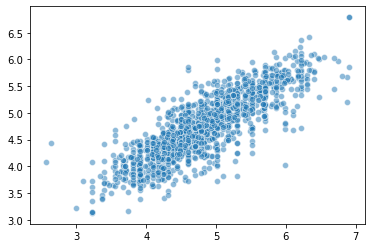

In [6]:
import seaborn as sns
sns.scatterplot(x=test.price_log.to_numpy(), y=m.predict(X_test).flatten(), alpha=0.5)

In [7]:
X_train.shape

(7243, 74)